# Lotka-Volterra Model with `pfmvn`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from jax import lax

from pfjax.particle_filter import particle_filter as pf
from pfjax import particle_filter_mvn as pfmvn
from pfjax.particle_filter import joint_loglik, particle_loglik
from pfjax import proj_data, simulate
from pfjax.lotvol_model import LotVolModel

## Simulate and Plot Data

Plotting the observations of the state (latent variables) as well as the observations. The latent observations are the smooth lines given below and the observations are the slightly more jagged lines.

In [45]:
key = random.PRNGKey(0)

# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.25
tau_l = 0.25

theta = np.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

dt = 0.1
n_res = 1
n_obs = 50
lotvol_model = LotVolModel(dt, n_res) 
key, subkey = random.split(key)

x_init = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                     theta=jnp.append(theta[0:6], jnp.array([0., 0.])),
                     key=subkey)

y_meas, x_state = simulate(lotvol_model, n_obs, x_init, theta, subkey)

array([4146024105,  967050713], dtype=uint32)

array([2718843009, 1272950319], dtype=uint32)

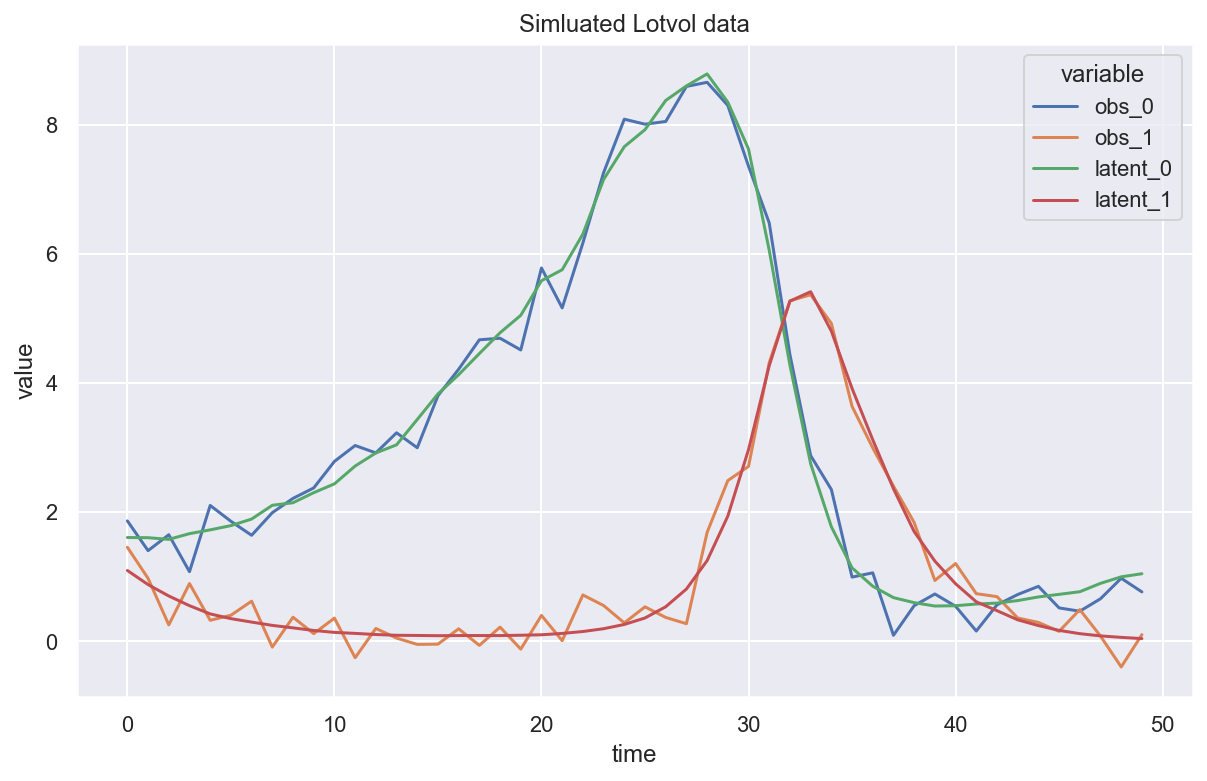

In [35]:
def make_df(data_arr, labels):
    """
    Make dataframe for Seaborn plotting
    data_arr = [y_meas, x_state]
    labels = ["obs_0", "obs_1", "latent_0", "latent_1"]
    """
    y_meas = data_arr[0]
    x_state = data_arr[1]
    df = pd.DataFrame(y_meas) 
    df.columns = labels[:2]
    df[labels[2]] = jnp.exp(jnp.squeeze(x_state)[:, 0])
    df[labels[3]] = jnp.exp(jnp.squeeze(x_state)[:, 1])
    df["time"] = df.index
    return df

true_data = make_df([y_meas, x_state],
                    labels=["obs_0", "obs_1", "latent_0", "latent_1"])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
sns.lineplot(data=pd.melt(true_data, id_vars = "time"), 
             x="time", y="value", hue="variable")\
    .set_title("Simluated Lotvol data");

## Particle Filter with MVN Approx.

$$
\ell(\theta \mid x_{0:T}, y_{0:T}) = \log p(y_0 \mid x_0, \theta) + \sum_{t=1}^T \log p(y_t \mid x_t, \theta) + \log p(x_t \mid x_{t-1}, \theta).
$$

In [36]:
theta_lims = np.array([[0.8, 1.2], [.75, 1.2], [3.5, 4.5], [0.8, 1.2],
                       [.05, .2], [.05, .2], [.1, .5], [.1, .5]])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]
n_pts = 100

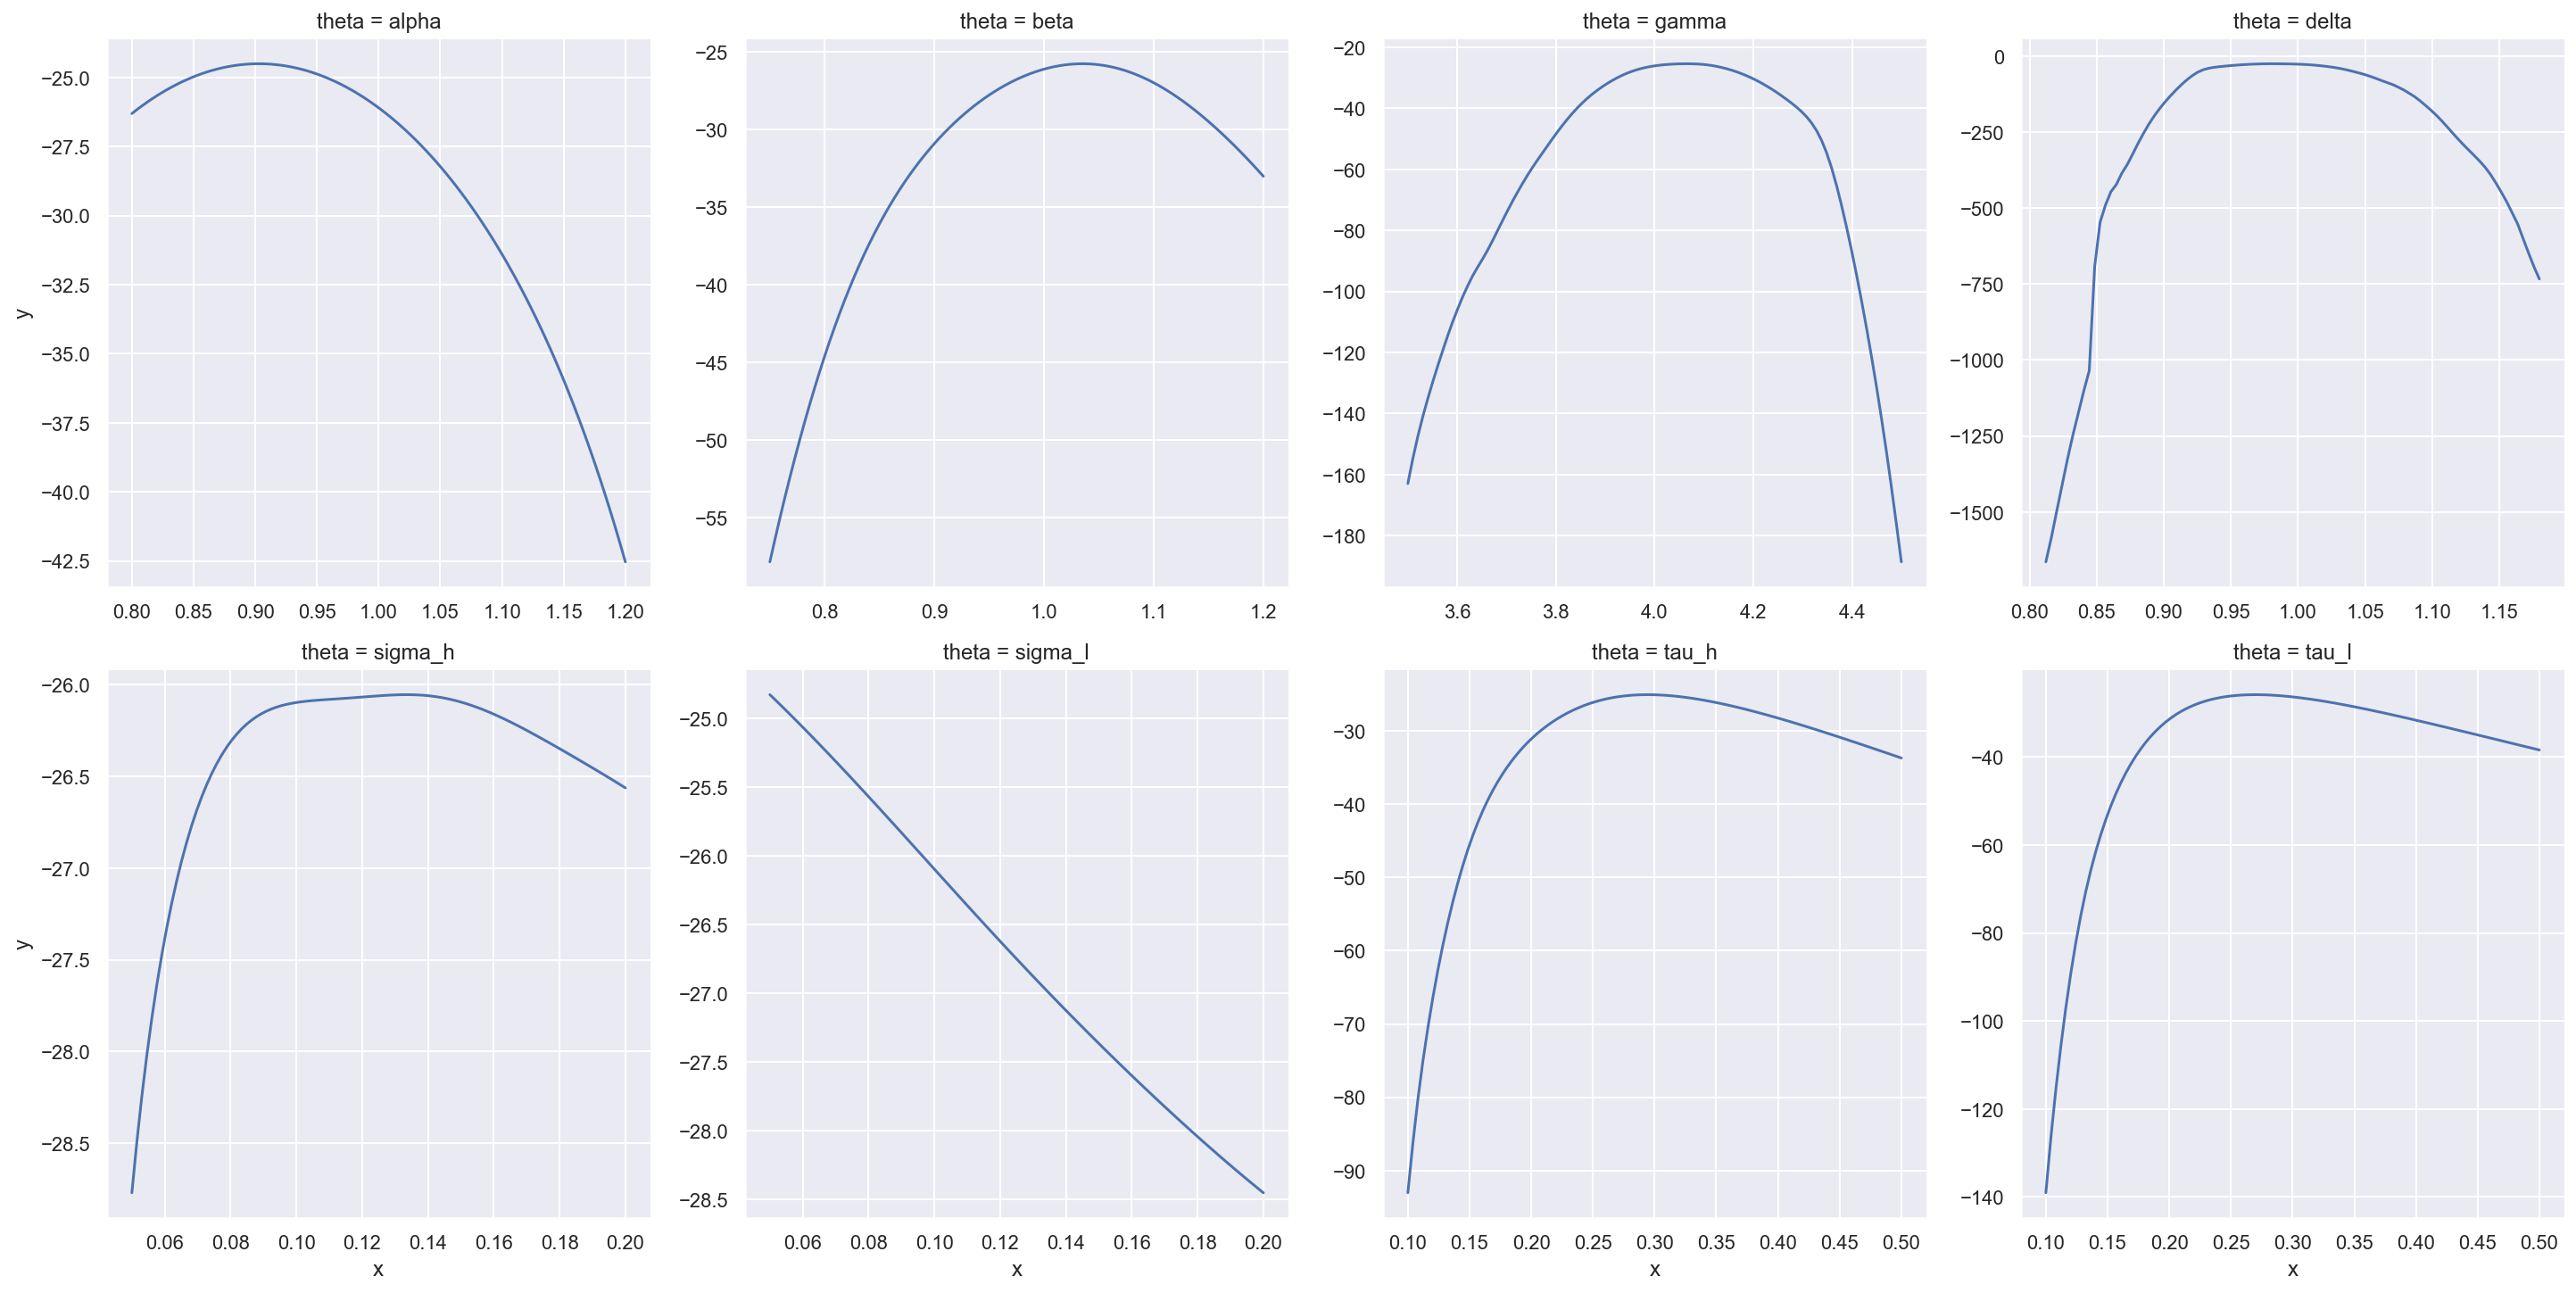

In [37]:
n_particles = 100

@jax.jit
def lotvol_pflik(theta):
    temp = pfmvn.particle_filter(theta=theta, model=lotvol_model, y_meas=y_meas,
                                 n_particles=n_particles, key=key)
    return particle_loglik(temp['logw_particles'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap=4,
    facet_kws=dict(sharex=False, sharey=False)
);

### Experimental Notes

- The MVN approximation makes the log-likelihood **much** smoother. This is noticable in the optimization, for example the bootstrap particle filter diverges for `{learning_rate = 1e-4, n_particles=1000}`, but the MVN approximation is able to converge with the same learning rate and half the particles (500). This is with the initial values as the true paramters. 
- 

In [38]:
from pfjax import stoch_opt 

In [39]:
params, so, grads = stoch_opt(lotvol_model, 
                              params = jnp.array([1.,1., 4., 1., 0.1, 0.1, 0.25, 0.25]), 
                            #   params = jnp.array(np.random.random(len(theta))),
                              grad_fun = pfmvn.get_sum_lweights_mvn, 
                              y_meas = y_meas, key=key, 
                              learning_rate=1e-5, 
                              iterations=1000, n_particles=50
                              ,mask=np.array([1,1,1,1,1,1,1,1]))

print("Estimated params: {0}".format(list(round(params, 1))))
print("True params: {0}".format(list(theta)))

Estimated params: [0.90000004, 1.0, 3.9, 1.0, 0.0, 0.0, 0.3, 0.3]
True params: [1.0, 1.0, 4.0, 1.0, 0.1, 0.1, 0.25, 0.25]


Text(0.5, 1.0, 'Simluated lotvol data from estimated params')

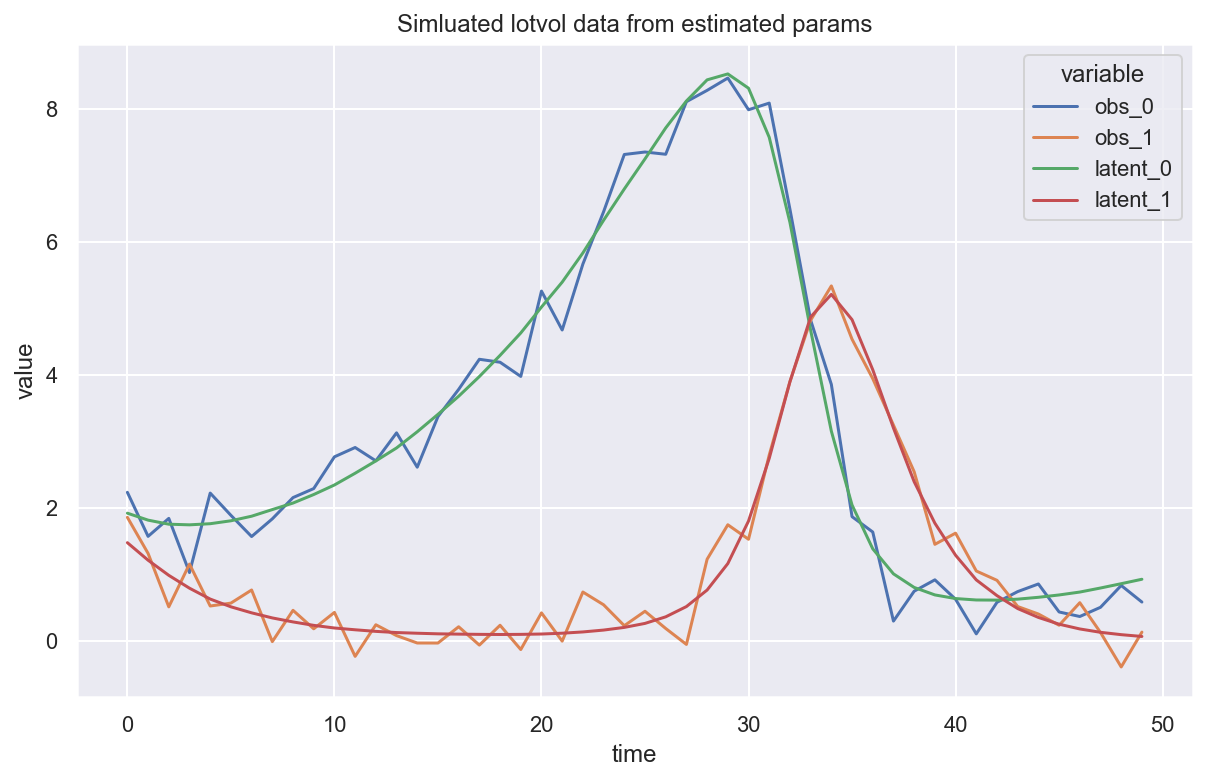

In [40]:
x_init_est = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                                  theta=params,
                                  key=subkey)

y_meas_est, x_state_est = simulate(lotvol_model, 
                                   n_obs, 
                                   x_init_est, 
                                   params, 
                                   subkey)

est_data = make_df([y_meas_est, x_state_est],
                    labels=["obs_0", "obs_1", "latent_0", "latent_1"])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
sns.lineplot(data=pd.melt(est_data, id_vars="time"),
             x="time", y="value", hue="variable")\
    .set_title("Simluated lotvol data from estimated params")


## Laplace Approximation

- Define priors: $\pi(\theta)$
- Construct posterior
- Find theta hat argmax(posterior)

**Dont understand**: Fisher information is the negative Hessian of the log-likelihood, which is the variance of the score function, but the score function is the first derivative of the log-likelihood. Alternatively, we can approximate the log-likelihood with a Laplace approximation for which we have the inverse of the Hessian as the variance parameter. So the variance of the log-likelihood and the variance of the Score function are the same thing? Or is this only if the log-likelihood is evaluated at the maxinimum (MLE)?

### TODO

- Fix prior to use JAX sampling and not Scipy/Numpy sampling
- Make sure I am managing the keys properly in this notebook. Should I recreate the keys everytime  they are used? That essentially means deleting keys every time they are used 

In [41]:
from jax.scipy.stats import multivariate_normal 
from jax import random

prior_means = theta
prior_cov = jnp.diag(theta)

def prior(x): 
    # will have to change this to use Jax sampling
    return multivariate_normal.pdf(
    x, prior_means, prior_cov)

params, so, grads = stoch_opt(lotvol_model,
                              params=jnp.array([1., 1., 4., 1., 0.1, 0.1, 0.25, 0.25]),
                            #   params=jnp.array(np.random.random(len(theta))*0.01),
                              grad_fun=pfmvn.log_posterior,
                              y_meas=y_meas, key=key,
                              learning_rate=1e-5, iterations=1000, 
                              n_particles=100, 
                              mask=np.array([1, 1, 1, 1, 1, 1, 1, 1]),
                              prior=prior)

print("Estimated params: {0}".format(list(round(params, 1))))
print("True params: {0}".format(list(theta)))

Estimated params: [0.90000004, 1.0, 3.9, 1.0, 0.0, 0.0, 0.3, 0.3]
True params: [1.0, 1.0, 4.0, 1.0, 0.1, 0.1, 0.25, 0.25]


In [42]:
# hessian: 
hessian = jax.jacfwd(jax.jacrev(pfmvn.log_posterior))

# should increase the number of particles here, since we want a one-time accurate approx. of the loglik
hess = hessian(params, key, n_particles=1000, y_meas=y_meas, model=lotvol_model, prior=prior)
theta_hat = params
var_hat = jnp.linalg.inv(hess)

In [69]:
n_post_samples = 2000
posterior_samples = random.multivariate_normal(key=key, mean=theta_hat, cov=-var_hat, shape=(n_post_samples, ))

# find 95% credible intervals
theta_U = jnp.quantile(posterior_samples, q=0.95, axis=0)
theta_L = jnp.quantile(posterior_samples, q=0.05, axis=0)

round(theta_L, 2), round(theta_U, 2)

theta_L = jnp.array(list(map(lambda x: max(x, 1e-4), theta_L))) # trickery to remove negative values from lower bound

(DeviceArray([ 0.84      ,  0.94      ,  3.59      ,  0.90999997,
              -0.03      , -0.08      ,  0.25      ,  0.22      ],            dtype=float32),
 DeviceArray([0.93, 1.04, 4.23, 1.05, 0.03, 0.14, 0.35, 0.31], dtype=float32))

In [71]:
# forward simulate data with lower confidence interval:
x_init_L = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                                    theta=theta_L,
                                    key=subkey)

y_meas_L, x_state_L = simulate(lotvol_model,
                               n_obs,
                               x_init_L,
                               theta_L,
                               subkey)
lower_bound = make_df([y_meas_L, x_state_L], 
                      labels = ["obs_0", "obs_1", "latent_0", "latent_1"])

# forward simulate data with upper confidence interval:
x_init_U = lotvol_model.init_sample(y_init=jnp.log(jnp.array([5., 3.])),
                                    theta=theta_U,
                                    key=subkey)

y_meas_U, x_state_U = simulate(lotvol_model,
                               n_obs,
                               x_init_U,
                               theta_U,
                               subkey)
upper_bound = make_df([y_meas_U, x_state_U], 
                      labels = ["obs_0", "obs_1", "latent_0", "latent_1"])

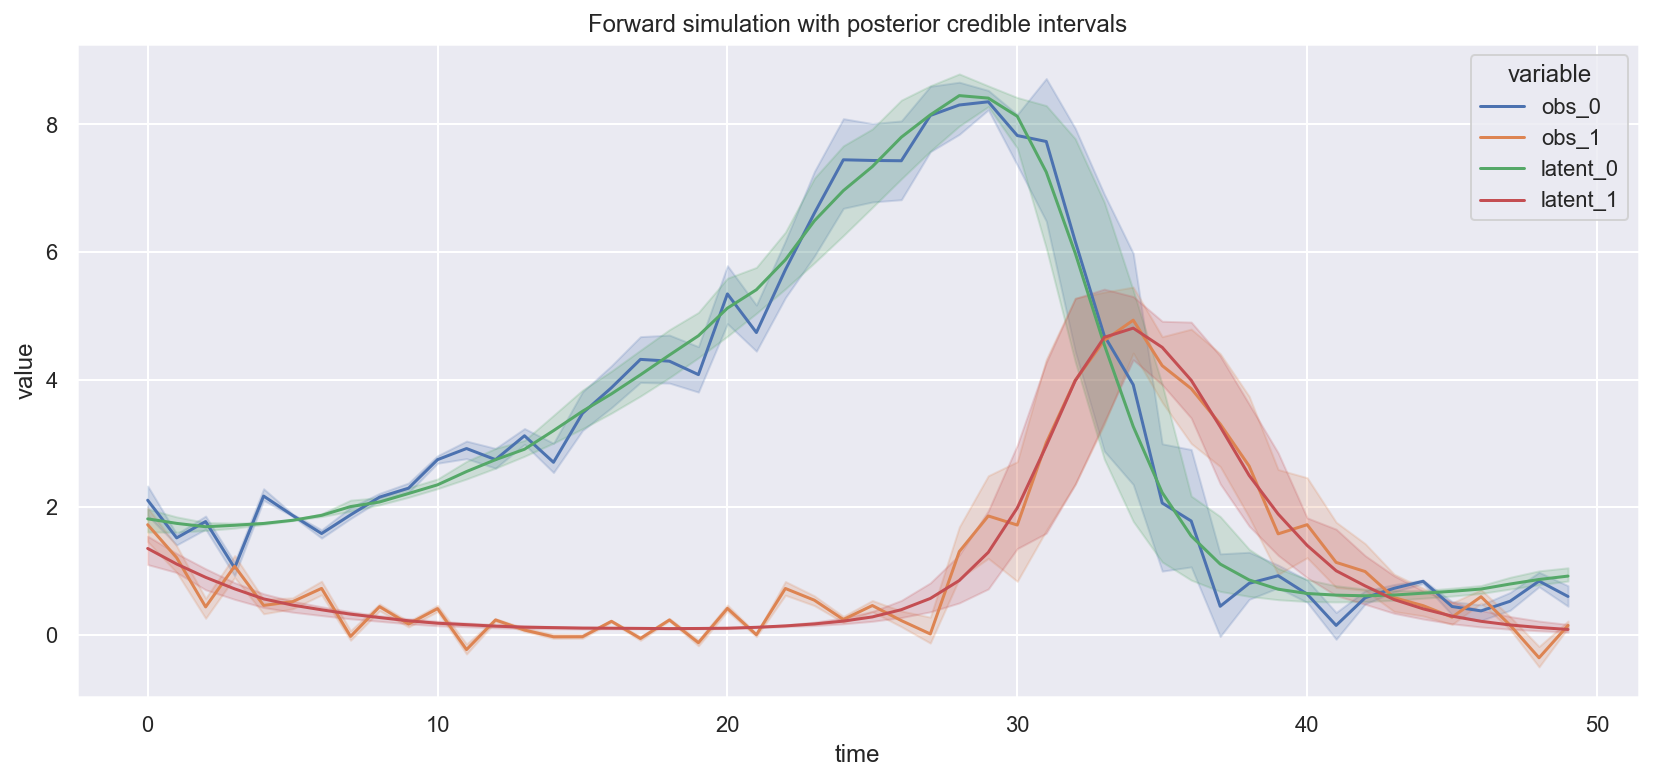

In [72]:
all_data = pd.concat([lower_bound, upper_bound, true_data]
                     ).reset_index(drop=True)
all_data = pd.melt(all_data, id_vars="time")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6), sharey=True)
sns.lineplot(data=all_data, x="time", y="value", hue="variable")\
    .set_title("Forward simulation with posterior credible intervals");